
**Andre Cianflone**

## Thompson sampling
Thompson sampling is an ingenious algorithm that implicitly balances exploration and exploitation based on quality and uncertainty. Let's say we sample a 3-armed bandit and model the probability that each arm gives us a positive reward. The goal is of course to maximize our rewards by pulling the most promising arm. Assume at the current timestep arm-3 has mean reward of 0.9 over 800 pulls, arm-2 has mean reward of 0.8 over 800 pulls, and arm-1 has mean reward of 0.78 over 10 pulls. So far, arm-3 is clearly the best. But if we were to explore, would we choose arm-2 or arm-1? An $\epsilon$-greedy algorithm would, with probability $\epsilon$, just as likely choose arm-3, arm-2, or arm-1. However, arm-2 has been examined many times, as many as arm-1, and has a mean reward lower than arm-1. Selecting arm-2 seems like a wasteful exploratory action. Arm-1 however, has a lower mean reward than either arm-2 or arm-3, but has only been pulled a few times. In other words, arm-1 has a higher chance of being a better action than arm-3 when compared to arm-2, since we are more *uncertain* about its true value. The $\epsilon$-greedy algorithm completely misses this point. Thompson sampling, on the other hand, incorporates uncertainty by modelling the bandit's Bernouilli parameter with a prior beta distribution.

The beauty of the algorithm is that it always chooses the action with the highest expected reward, with the twist that this reward is weighted by *uncertainty*. It is in fact a Bayesian approach to the bandit problem. In our Bernouilli bandit setup, each action $k$ returns reward of 1 with probability $\theta_k$, and 0 with probability $1-\theta_k$. At the beginning of a simulation, each $\theta_k$ is sampled from a uniform distribution $\theta_k \sim Uniform(0,1)$ with $\theta_k$ held constant for the rest of that simulation (in the stationary case). The agent begins with a prior belief of the reward of each arm $k$ with a beta distribution, where $\alpha = \beta = 1$. The prior probability density of each $\theta_k$ is:

$$
p(\theta_k) = \frac{\Gamma(\alpha_k + \beta_k)}{\Gamma(\alpha_k)\Gamma(\beta_k)} \theta_k^{\alpha_k -1} (1-\theta_k)^{\beta_k-1}
$$

An action is chosen by first sampling from the beta distribution, followed by choosing the action with highest mean reward:
$$
x_t = \text{argmax}_k (\hat{\theta}_k), \quad \hat{\theta}_k \sim \text{beta}(\alpha_k, \beta_k)
$$

According to Bayes' rule, an action's posterior distribution is updated depending on the reward $r_t$ received:
$$
(\alpha_k, \beta_k) = (\alpha_k, \beta_k) + (r_t, 1-r_t)
$$

Thus the actions' posterior distribution are constantly updated throughout the simulation. We will measure the Thompson algorithm by comparing it with the $\epsilon$-greedy and Upper Confidence Bound (UCB) algorithms using *regret*. The per-period regret for the Bernouilli bandit problem is the difference between the mean reward of the optimal action minus the mean reward of the selected action:
$$
\text{regret}_t(\theta) = \max_k \theta_k - \theta_{x_t}
$$

First we setup the necessary imports and the standard k-armed bandit. The *get_reward_regret* samples the reward for the given action, and returns the regret based on the true best action.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret


We implement the two beta algorithms from [1], although we focus only on the Thompson algorithm. For the Bernouilli-greedy algorithm, the Bernouilli parameters are the expected values of the Beta distribution, i.e.:
$$
\mathbb{E}(x_k) = \frac{\alpha_k}{(\alpha_k + \beta_k)}
$$

The Thompson algorithm follows the pseudocode below, based on [1], here we assume $K$ arms


**Algorithm: Thompson($K$,$\alpha$, $\beta$)**  
for $t$ = 1,2, ..., do  
  &nbsp;&nbsp; // sample action parameter from beta distribution  
  &nbsp;&nbsp; for $k = 1, \dots, K$ do  
  &nbsp;&nbsp; &nbsp;&nbsp; Sample $\hat{\theta}_k \sim \text{beta}(\alpha_k, \beta_k)$  
  &nbsp;&nbsp; end for
  
  &nbsp;&nbsp; // select action, get reward  
  &nbsp;&nbsp; $x_t \leftarrow \text{argmax}_k \hat{\theta}_k$  
  &nbsp;&nbsp; $r_t \leftarrow \text{observe}(x_t)$  
  
  &nbsp;&nbsp; // update beta parameters  
  &nbsp;&nbsp; $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t})+(r_t, 1-r_t)$  
end for
  

In [0]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()
  
class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()


For comparison, we also implement the $\epsilon$-greedy algorithm and Upper Confidence Bound (UBC) algorithm. The implementations are based on [2] (pages 24-28). The $\epsilon$-greedy algorithm is straightforward and explained briefly above. Note in this implementation we make use of the incremental update rule. That is, to update the $Q$-value of each action, we maintain a count of each action. For action $k$ taken at time $t$:
$$
\begin{align}
r_t &\leftarrow \text{observe}(k) \\
N(k) &\leftarrow N(k) + 1 \\
Q(k) &\leftarrow Q(k) + \frac{1}{N(k)}[r_t-Q(k)] \\
\end{align}
$$

In [0]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

The UCB action selection is different to the $\epsilon$-greedy. Like the Thompson algorithm, it includes a measure of uncertainty. The selected action follows the rule:
$$
A_t = \text{argmax}_a \left[ Q_t(a) + c \sqrt{\frac{\ln t}{N_t (a)}} \right]
$$

Where $N_t (a)$ is the number of times action $a$ has been selected up to time $t$. As the denominator grows in the square root expression, the added effect on $Q_t(a)$ diminishes. This uncertainty measure is weighed by the hyperparameter $c$. The disadvantage is that, unlike the Thompson algorithm, this uncertainty hyperparameter requires tuning. Fundamentally, **the UCB uncertainty is deterministic and beneficial**, whereas **in the Thompson case, uncertainty increases the expected reward variance**. Since the Thompson algorithm samples the mean rewards from a beta distribution, the actions with high variance may not only have a higher chance of being chosen, but may also have a lower chance. 

In [0]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

Below are some helper functions. The function *simulate* will simulate the learning for a single algorithm and return the mean regrets over a number of trials. The *experiment* function runs the simulations over all algorithms and plots their mean regrets

In [0]:

def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

## Experiments
For all experiments, in each trial the agents are allowed 1000 timesteps to maximize reward. We perform 5000 trials for each experiment.

### Baseline
In this first experiment, we aim for a standard setup, inspired by the bandit testbed in Chapter 2 of [2]. We set $\epsilon=0.1$ for the $\epsilon$-greedy algorithm, and $c=2$ for UCB. As can be seen in the chart below, the Thompson and $\epsilon$-greedy agents quickly converge to a steady regret value after only 200 steps. The UCB agent on the other hand very slowly decreases, lagging behind the two other agents, and continues in its downward trend even at step 1000. This suggests the non-Thompson agents could benefit from parameter tuning, whereas the Thompson agent works well right off the bat.

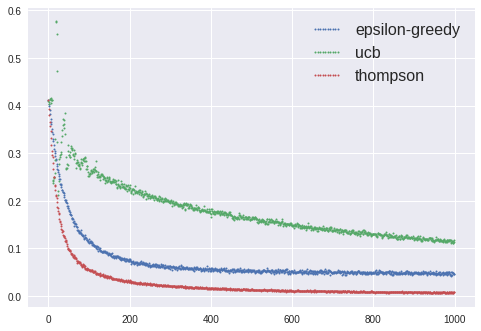

In [0]:

# Experiment 1
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)


### Being greedier
After fiddling with UCB's $c$ parameter, we can see that if it is set to 0.1, it quickly converges to a low regret value, after only a few dozen steps and now outperforms $\epsilon$-greedy with very little variance. Note that at first it outperforms Thompson, but not in the long run. Decreasing UCB's $c$ basically decreased the "premium" the agent adds to uncertainty. This encourages UCB to be more "greedy", hence why it converges quickly. Yet it still does not outperform Thompson. Given this intuition, we also make $\epsilon$-greedy greedier, decreasing its hyperparameter to 0.03. We can see that after 1000 steps, it does outperform the previous $\epsilon$-greedy, but only marginally. Also, this comes at the cost of converging much more slowly. We do not observe the massive swing as observed with UCB, even if we continue to lower $\epsilon$.
It's possible that given only 10 actions, being greedy is a better solution, and exploring is costly and unnecessary, leading us to the next experiment.

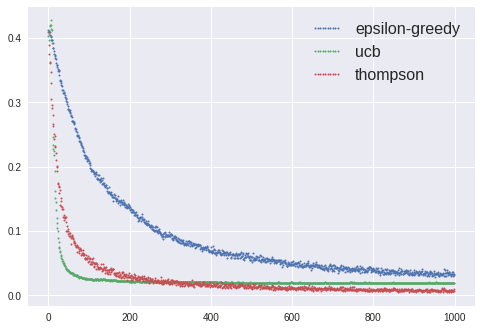

In [0]:

# Experiment 2
arm_count = 10 # number of arms in bandit
epsilon = 0.03
ucb_c = 0.1
stationary=True
experiment(arm_count)

### Large action space
In this setting, we increase the number of actions from 10 to 200, leaving the other parameters equal to our baseline. The $\epsilon$-greedy agent barely budges in its learning pattern when compared to the baseline. The Thompson agent very slowly, but surely, decreases regret to eventually outperform $\epsilon$-greedy around step 700, another vote of confidence for Thompson. On the other hand, UCB is drastically unstable and diverges. This behaviour is not only due to the increase in action space, but due to the fact that the Bernouilli reward probabilities are so close to each other. Recall that regret is calculated as the difference between the optimal $\theta_k$ and the action $\hat{\theta}_k$. Since the true $\theta_k$ are sampled from a uniform distribution, they are evenly spread between 0 and 1. The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action. Thompson and UCB, on the other hand, with their emphasis on exploration, give a high premium to exploring actions not yet seen. Since there are so many actions, and since the mean rewards are evenly distributed between 0 and 1, there is a high cost of constantly exploring actions with rewards close to 0. Noticeably, the Thompson algorithm is incredibly stable across time, despite the large action space. Due to its sampling nature, it has a lower probability than UCB of constantly taking suboptimal actions.

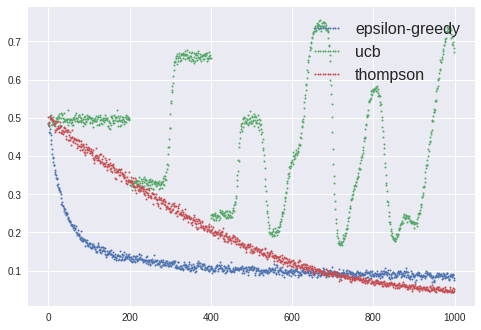

In [0]:
# Experiment 3
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

We now lower UCB's $c$ variable and observe a dramatic increase in stability, which even leads it to outperform all other algorithms. However, the Thompson agent still seems to be on a decreasing regret trend around 1000 steps without having converged, in between $\epsilon$-greedy and UCB.

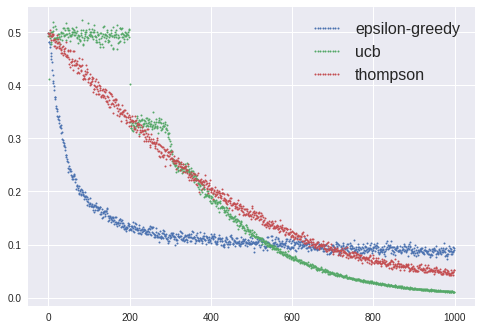

In [0]:
# Experiment 4
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count)

In the graph below, increasing the timesteps to 3000 confirms that Thompson and UCB closely converge.

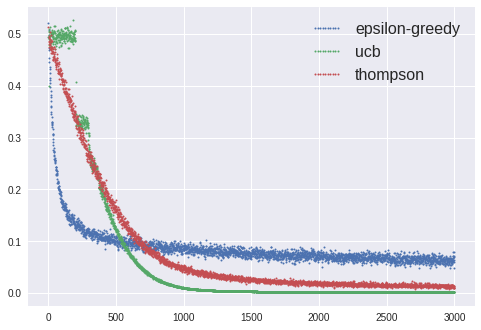

In [0]:
# Experiment 5
arm_count = 200 # number of arms in bandit
epsilon = 0.1
ucb_c = 0.01
stationary=True
experiment(arm_count, timesteps=3000, simulations=1000)

### Non-stationarity
We now reset our parameters to the baseline settings: 10-arm bandit, $\epsilon=0.1$ and UCB-c value of 2. However, we now set the environment to being non-stationary. Actually, after every 100 steps, the bandit resamples the action Bernouilli parameters. This places special emphasis on exploration. An algorithm that converges to an action and does not emphasize exploration will perform quite poorly as the true reward distribution changes over time. Below we see a clear jump in regret every time the true bandit parameters are resampled (every 100 steps). While the $\epsilon$-greedy and Thompson's regret quickly decrease, on average they increase over time. On the other hand, UCB reacts much more quickly to the bandit non-stationarity, and actually continues to improve in regret over time, no doubt due to its higher emphasis on exploration. We confirm this in the next experiment.

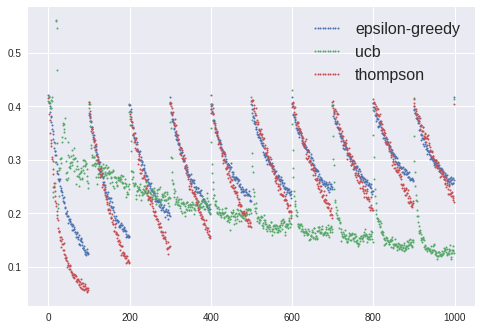

In [0]:
# Experiment 6
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

We now set UCB's $c$ parameter to 0.1 as we did in Experiment 2. Due to Experiment 2's setup, we concluded a greedier version of UCB would perform better in that setup, which it did. In the current setup, we can observe that the greedy UCB performs quite poorly and much like the other algorithms. Since we prefer a more exploratory algorithm, we fine tune $\epsilon$-greedy to be much less greedy and observe that it does not perform well. In fact, after trying for $\epsilon \in \{0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9\}$,  $\epsilon$-greedy performs the same as in the chart below.

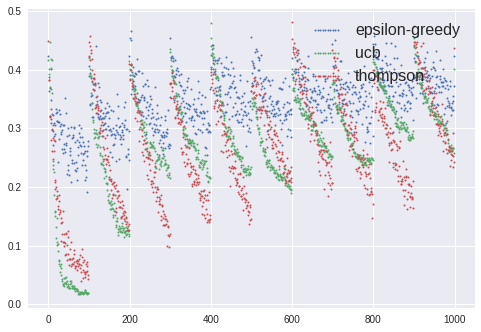

In [0]:
# Experiment 7
arm_count = 10 # number of arms in bandit
epsilon = 0.6
ucb_c = 0.1
stationary=False
experiment(arm_count)

We have seen the advantages and disadvantages of various algorithms. The Thompson algorithm has been shown to perform quite well in various settings without any necessary parameter tuning to boot. In some cases, UCB performed close to Thompson, but required fine tuning. Exceptionally, UCB dealt better than Thompson in the non-stationary setup, but only after tuning its hyperparameter. Notably, in no cases was $\epsilon$-greedy the best performing agent.

## References
[1]: Russo, Daniel, Benjamin Van Roy, Abbas Kazerouni, and Ian Osband. "A Tutorial on Thompson Sampling." arXiv preprint arXiv:1707.02038 (2017). [link](https://arxiv.org/abs/1707.02038)

[2]: Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1, no. 1. Cambridge: MIT press, 1998.